In [ ]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import IPython
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
#import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from scipy import signal
import itertools

#adsjfalkdfjalkdsjfkladjslf

In [3]:
# Create the MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx]))

Loading data and QC data

In [ ]:
# Loading data
filetwo=pd.ExcelFile('Trinity_WindFarm_2.xlsx')
df_DataGen=pd.read_excel(filetwo,'DataGen')
df_Obs_Weather=pd.read_excel(filetwo,'Obs_Weather')
# Set DT type for DateTime column
df_DataGen["DateTime"]=pd.to_datetime(df_DataGen["DateTime"])
df_Obs_Weather["DateTime"]=pd.to_datetime(df_Obs_Weather["DateTime"])
df_DataGen.set_index('DateTime', inplace=True)
df_Obs_Weather.set_index('DateTime', inplace=True)
# Check range for discrepancies 
print("head")
print(df_DataGen.head)
#print(df_DataGen.tail(5))
#print("adfjaksdflasd")

df = df_Obs_Weather.iloc[np.r_[0:5, -5:0]]
print (df)

#print(df_DataGen)
#print(df_Obs_Weather)


head
<bound method NDFrame.head of                      Grand Total
DateTime                        
2024-01-01 00:00:00   152.274307
2024-01-01 01:00:00   146.943688
2024-01-01 02:00:00   131.464828
2024-01-01 03:00:00   118.197630
2024-01-01 04:00:00    86.455345
...                          ...
2025-03-28 19:00:00   152.715743
2025-03-28 20:00:00   174.989570
2025-03-28 21:00:00   185.220748
2025-03-28 22:00:00   183.265050
2025-03-28 23:00:00   182.385897

[10870 rows x 1 columns]>
                     TEMPERATURE  RELATIVE_HUMIDITY  WIND_SPEED  \
DateTime                                                          
2024-01-01 00:00:00         38.1                 71        12.0   
2024-01-01 01:00:00         38.0                 73        12.4   
2024-01-01 02:00:00         36.4                 73        13.1   
2024-01-01 03:00:00         34.8                 73        12.3   
2024-01-01 04:00:00         33.6                 74        10.4   
2025-05-26 14:00:00         84.5        

In [5]:
# Check the shape before we resample
print(df_DataGen.shape)
print(df_Obs_Weather.shape)
# Resample in order to keep real datapoints when inner joining concatenation
df_DataGen=df_DataGen.resample('1H').mean()
df_Obs_Weather=df_Obs_Weather.resample('1H').mean()
#check to find the new dimensions of the dataframes
print(df_DataGen.shape)
print(df_Obs_Weather.shape)

(10870, 1)
(12264, 5)
(10872, 1)
(12283, 5)


C:\Users\khong\AppData\Local\Temp\ipykernel_34112\3588818394.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_DataGen=df_DataGen.resample('1H').mean()
C:\Users\khong\AppData\Local\Temp\ipykernel_34112\3588818394.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_Obs_Weather=df_Obs_Weather.resample('1H').mean()


There are 2 empty rows in df_DataGen and 19 empty rows in df_Obs_Weather

In [6]:
# Drop some rows off Obs_Weather 12283 - 10872 = 1411 rows dropped and concat them
df_Total_Data = pd.concat([df_DataGen, df_Obs_Weather], axis=1, join="inner")
print(df_Total_Data.head)
print(df_Total_Data.shape)

<bound method NDFrame.head of                      Grand Total  TEMPERATURE  RELATIVE_HUMIDITY  WIND_SPEED  \
DateTime                                                                       
2024-01-01 00:00:00   152.274307         38.1               71.0        12.0   
2024-01-01 01:00:00   146.943688         38.0               73.0        12.4   
2024-01-01 02:00:00   131.464828         36.4               73.0        13.1   
2024-01-01 03:00:00   118.197630         34.8               73.0        12.3   
2024-01-01 04:00:00    86.455345         33.6               74.0        10.4   
...                          ...          ...                ...         ...   
2025-03-28 19:00:00   152.715743         78.9               43.0        11.6   
2025-03-28 20:00:00   174.989570         72.1               52.0        11.8   
2025-03-28 21:00:00   185.220748         69.3               59.0        13.8   
2025-03-28 22:00:00   183.265050         66.6               66.0        14.1   
2025-03-28

In [7]:
# Check if anydata is missing. 
value = df_Total_Data.isnull().values.any()
print(value)
null_records = df_Total_Data[df_Total_Data.isnull().any(axis=1)]

# 2024-03-10 02:00:00 and 2025-03-09 02:00:00 have all null values(Daylight Savings Time) and will be dropped

df_Total_Data = df_Total_Data.drop("2024-03-10 02:00:00")

df_Total_Data = df_Total_Data.drop("2025-03-09 02:00:00")

# Print the rows
print(null_records)

# Linear Interpolate the rest of the missing values

df_Total_Data = df_Total_Data.interpolate(method = 'linear')
#print(df_Total_Data.shape)



True
                     Grand Total  TEMPERATURE  RELATIVE_HUMIDITY  WIND_SPEED  \
DateTime                                                                       
2024-02-21 12:00:00   102.842433          NaN                NaN         NaN   
2024-02-21 13:00:00   109.885302          NaN                NaN         NaN   
2024-02-21 14:00:00   144.246900          NaN                NaN         NaN   
2024-02-21 15:00:00   172.012505          NaN                NaN         NaN   
2024-02-21 16:00:00   176.412855          NaN                NaN         NaN   
2024-02-21 17:00:00   187.604050          NaN                NaN         NaN   
2024-02-22 12:00:00    95.416098          NaN                NaN         NaN   
2024-02-22 13:00:00   136.096968          NaN                NaN         NaN   
2024-02-22 14:00:00   155.540160          NaN                NaN         NaN   
2024-02-22 15:00:00   164.091570          NaN                NaN         NaN   
2024-02-22 16:00:00   175.181850   

In [8]:
# Check to make sure all the null vales have been interpolated
value = df_Total_Data.isnull().values.any()
print(value)

False


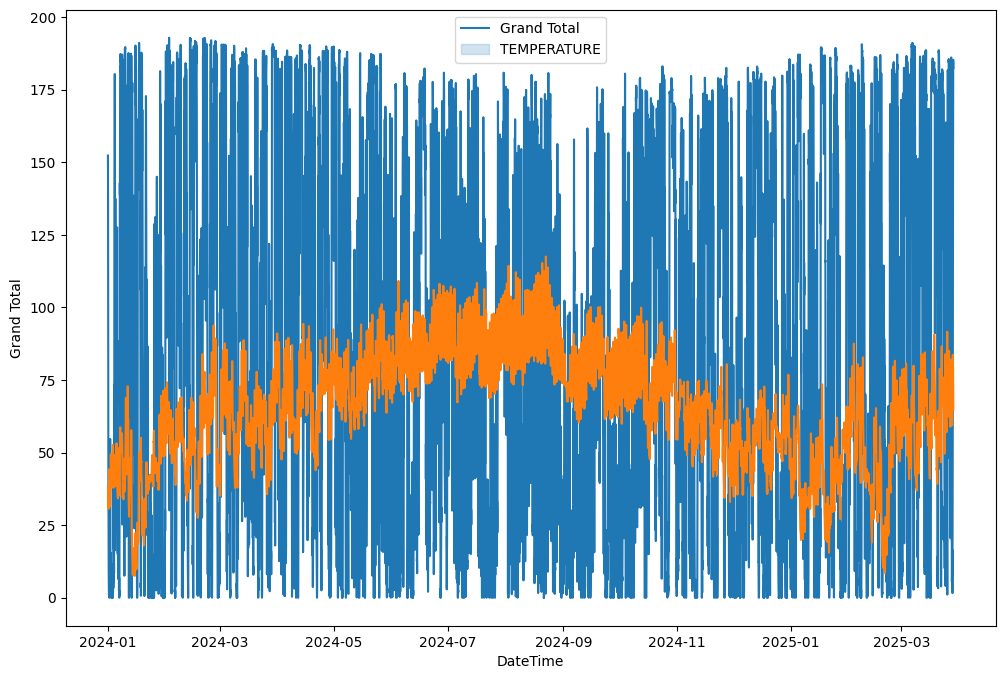

In [9]:
# Plot Temp and Grand Total vs. Time
plt.figure(figsize=(12,8))
sns.lineplot(x=df_Total_Data.index, y=df_Total_Data['Grand Total'])
sns.lineplot(x=df_Total_Data.index, y=df_Total_Data['TEMPERATURE'])
plt.legend(['Grand Total', 'TEMPERATURE'])

Our findings are that during the Summer we observed less wind output than in Winter. However a normalized graph would yield clearer results.

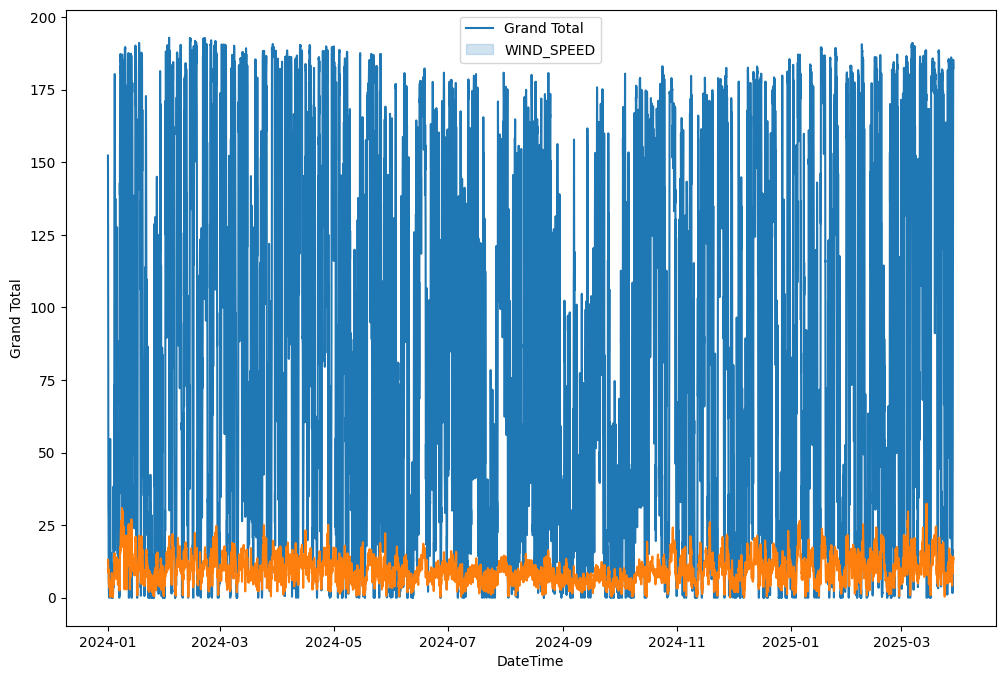

In [10]:
# Plot Temp and Grand Total vs. Time
plt.figure(figsize=(12,8))
sns.lineplot(x=df_Total_Data.index, y=df_Total_Data['Grand Total'])
sns.lineplot(x=df_Total_Data.index, y=df_Total_Data['WIND_SPEED'])
plt.legend(['Grand Total', 'WIND_SPEED'])

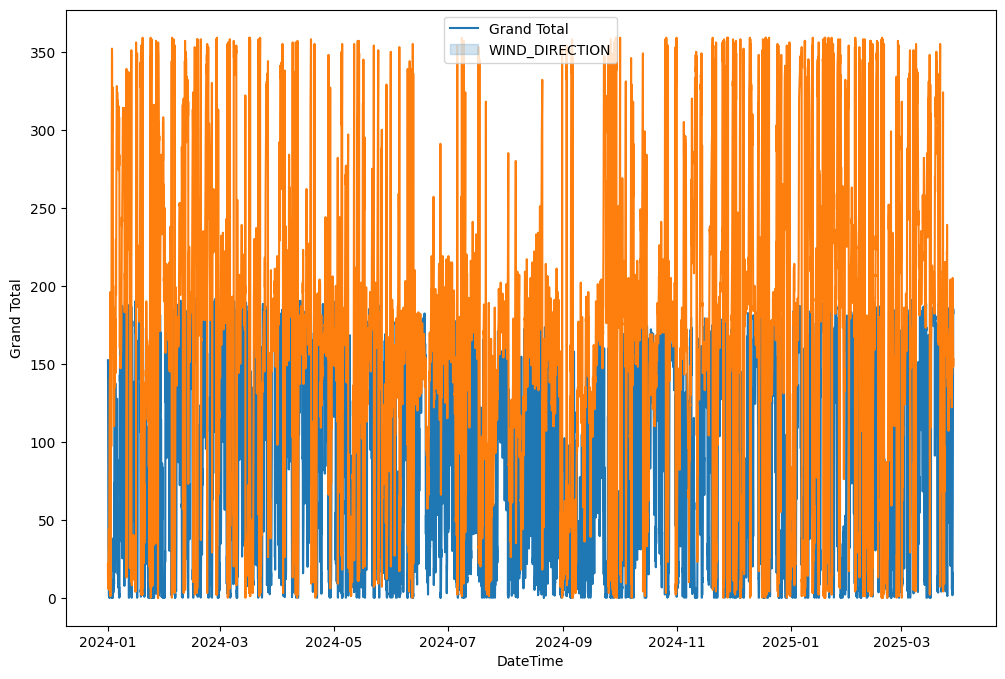

In [11]:
# Plot Temp and Grand Total vs. Wind Direction
plt.figure(figsize=(12,8))
sns.lineplot(x=df_Total_Data.index, y=df_Total_Data['Grand Total'])
sns.lineplot(x=df_Total_Data.index, y=df_Total_Data['WIND_DIRECTION'])
plt.legend(['Grand Total', 'WIND_DIRECTION'])

The graphs are still pretty useless without normalization. But we still find evidence that during the Summer the winds are milder than in colder months.

In [12]:
df_Total_Data.dtypes

Grand Total                float64
TEMPERATURE                float64
RELATIVE_HUMIDITY          float64
WIND_SPEED                 float64
WIND_DIRECTION             float64
PRESSURE_MEAN_SEA_LEVEL    float64
dtype: object

In [13]:
#Create datasets for training and testing
target='Grand Total'
Y0=df_Total_Data[target]

feature=['TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED', 'WIND_DIRECTION', 'PRESSURE_MEAN_SEA_LEVEL']
X0=df_Total_Data[feature]

X_tr0, X_ts0, Y_tr0, Y_ts0 = train_test_split(X0, Y0, test_size=0.2, shuffle=False)

print(X_tr0.shape)

(8696, 5)


Next we will fit a regression model

In [14]:
import time

start_time1 = time.time()

# fitting a RF model with selected features
model_RF0 = RandomForestRegressor(random_state=1)
model_RF0.fit(X_tr0, Y_tr0)
# getting forecasts for the test set
pred_ts = model_RF0.predict(X_ts0)
pred_tr = model_RF0.predict(X_tr0)

# computing MAE error
print(f"MAPE of RF with selected features is {mean_absolute_percentage_error(Y_ts0, pred_ts)}")
print(f"MAPE of RF with selected features is {mean_absolute_percentage_error(Y_tr0, pred_tr)}")

print("RF model fitting takes %s seconds" % (time.time() - start_time1))

start_time2 = time.time()

MAPE of RF with selected features is 6.081238525344959
MAPE of RF with selected features is 1.9128364187631524
RF model fitting takes 20.03626537322998 seconds


In [15]:
model_xgb0 = xgboost.XGBRegressor()
model_xgb0.fit(X_tr0, Y_tr0)
pred_XGB0 = model_xgb0.predict(X_ts0)

# Base Model Benchmark is ~6.1% MAPE

print(f"MAPE of RF with selected features is {mean_absolute_percentage_error(Y_ts0, pred_XGB0)}")
#XGBoost MAPE is ~6.3%


MAPE of RF with selected features is 6.2861474518061025


In [16]:
# Adding Windspeed Polynomial Features
df_Total_Data['Windspeed_x2'] = df_Total_Data['WIND_SPEED']**2
df_Total_Data['Windspeed_x3'] = df_Total_Data['WIND_SPEED']**3

# Adding the Calender Features
df_Total_Data['hour'] = df_Total_Data.index.hour
df_Total_Data['month'] = df_Total_Data.index.month
#df_Total_Data['day_of_year'] = df_Total_Data.index.dayofyear
# Sometimes will  cause the accuracy to drop

#Adding trigonometric hour in order to represent its cyclic nature
df_Total_Data[f"hour_sin"] = np.sin(2 * np.pi *  df_Total_Data['hour'] / 24)
df_Total_Data[f"hour_cos"] = np.cos(2 * np.pi * df_Total_Data['hour'] / 24)

#Adding trigonometric hour in order to represent its cyclic nature
df_Total_Data['month_sin'] = np.sin((df_Total_Data['month'] - 1) * (2 * np.pi / 12))
df_Total_Data['month_cos'] = np.cos((df_Total_Data['month'] - 1) * (2 * np.pi / 12))


df_Total_Data['WIND_DIRECTION_cos'] = np.cos((df_Total_Data['WIND_DIRECTION'] ) * (2 * np.pi / 360))
df_Total_Data['WIND_DIRECTION_sin'] = np.sin((df_Total_Data['WIND_DIRECTION'] ) * (2 * np.pi / 360))

theta_rad = np.radians(df_Total_Data['WIND_DIRECTION'])

# Create u (east-west) and v (north-south) components
df_Total_Data['wind_u'] = df_Total_Data['WIND_SPEED'] * np.sin(theta_rad)
df_Total_Data['wind_v'] = df_Total_Data['WIND_SPEED'] * np.cos(theta_rad)

In [17]:
feature2=['TEMPERATURE', 'RELATIVE_HUMIDITY', 'WIND_SPEED', 'WIND_DIRECTION', 'PRESSURE_MEAN_SEA_LEVEL', 'Windspeed_x2', 'Windspeed_x3','hour', 'month', 'month_sin', 'month_cos']
X0=df_Total_Data[feature2]

X_tr0, X_ts0, Y_tr0, Y_ts0 = train_test_split(X0, Y0, test_size=0.2, shuffle=False)

In [18]:
# fitting a RF model with selected features
model_RF0 = RandomForestRegressor(random_state=1)
model_RF0.fit(X_tr0, Y_tr0)
# getting forecasts for the test set
pred_ts = model_RF0.predict(X_ts0)
pred_tr = model_RF0.predict(X_tr0)

# computing MAE error
print(f"MAPE of RF with selected features is {mean_absolute_percentage_error(Y_ts0, pred_ts)}")
print(f"MAPE of RF with selected features is {mean_absolute_percentage_error(Y_tr0, pred_tr)}")

MAPE of RF with selected features is 4.207039495863508
MAPE of RF with selected features is 1.34844140449868


After adding the polynomial features the accuracy improves from 6.3% to 6.2%. 

After adding the Calender features the accuracy improves from 6.2% to 4.26%.

After adding the month cyclic feature the accuracy improves from 4.26% to ~4.21%

Fine tuning with Hyper-Parameters

In [37]:
best_random = RandomForestRegressor(max_depth=50,
                                    max_features="log2",
                                    min_samples_split=10,
                                    min_samples_leaf=5,
                                    n_estimators=200,
                                    bootstrap=True,random_state=2)

best_random.fit(X_tr0, Y_tr0)
# getting forecasts for the test set
pred_ts = best_random.predict(X_ts0)
pred_tr = best_random.predict(X_tr0)

# computing MAE error
print(f"MAPE of RF with selected features is {mean_absolute_percentage_error(Y_ts0, pred_ts)}")
print(f"MAPE of RF with selected features is {mean_absolute_percentage_error(Y_tr0, pred_tr)}")

MAPE of RF with selected features is 4.87264929023056
MAPE of RF with selected features is 3.496775041779706


min_samples_leaf = 1 -> 5 brings the MAPE from 4.91% to 4.87%


Read the 4 year file 

ValueError: Excel file format cannot be determined, you must specify an engine manually.